<a href="https://colab.research.google.com/github/Steven-Macas/kmeans_mall_customers/blob/main/clientes_aprendizaje_automatico_no_supervisado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***APRENDIZAJE AUTOMÁTICO***

---



***NO SUPERVISADO***

En el dataset se encuentran datos relativos a factores socioeconómicos y de salud que determinan el desarrollo de un país.

## ***Librerías***

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import OneHotEncoder

## **Cargar DataSet y primera vista**

In [2]:
df = pd.read_csv('Mall_Customers.csv', index_col = 'CustomerID');

In [3]:
df.tail()

,Gender,Age,Annual Income (k$),Spending Score (1-100)
CustomerID,,,,
196,Female,35,120,79
197,Female,45,126,28
198,Male,32,126,74
199,Male,32,137,18
200,Male,30,137,83


In [4]:
df.dtypes

Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

## ***Preprocesar los datos***

In [5]:
# Cambiar el nombre de las columnas y limpiarlas
df = df.rename(columns={
    'CustomerID': 'customer_id',
    'Gender': 'gender',
    'Age': 'age',
    'Annual Income (k$)': 'annual_income',
    'Spending Score (1-100)': 'spending_score'
})

# Convertir los nombres de las columnas a minúsculas y eliminar espacios y símbolos extraños
df.columns = df.columns.str.lower().str.replace('[^\w\s]', '').str.replace(' ', '_')

<ipython-input-5-f2a87e6ee2b1>:11: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.lower().str.replace('[^\w\s]', '').str.replace(' ', '_')


In [6]:
df['gender'] = df['gender'].replace({'Male': 0, 'Female': 1})

In [7]:
df.isnull().sum()

gender            0
age               0
annual_income     0
spending_score    0
dtype: int64

In [8]:
df.describe()

,gender,age,annual_income,spending_score
count,200.000000,200.000000,200.000000,200.000000
mean,0.560000,38.850000,60.560000,50.200000
std,0.497633,13.969007,26.264721,25.823522
min,0.000000,18.000000,15.000000,1.000000
25%,0.000000,28.750000,41.500000,34.750000
50%,1.000000,36.000000,61.500000,50.000000
75%,1.000000,49.000000,78.000000,73.000000
max,1.000000,70.000000,137.000000,99.000000


In [9]:
df.tail()

,gender,age,annual_income,spending_score
CustomerID,,,,
196,1,35,120,79
197,1,45,126,28
198,0,32,126,74
199,0,32,137,18
200,0,30,137,83


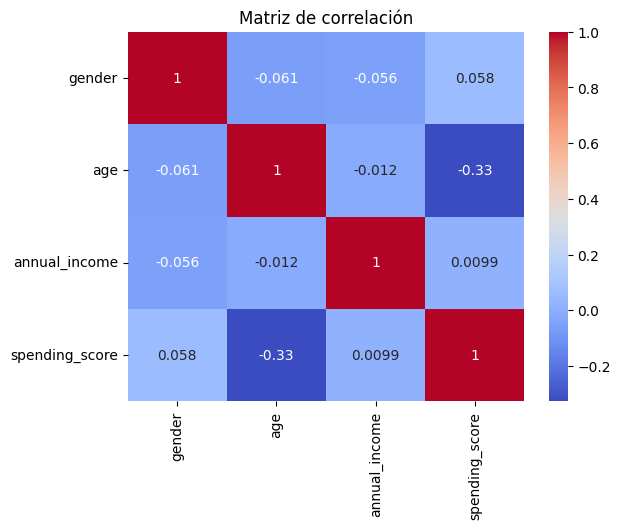

In [10]:
# Realizamos un pequeño análisis estadístico para elegir las variables más relevantes
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Matriz de correlación')
plt.show()

## ***Escalar y detectar OutLiers***

<ipython-input-11-b5273d12130e>:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())


array([[<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'spending_score'}>]], dtype=object)

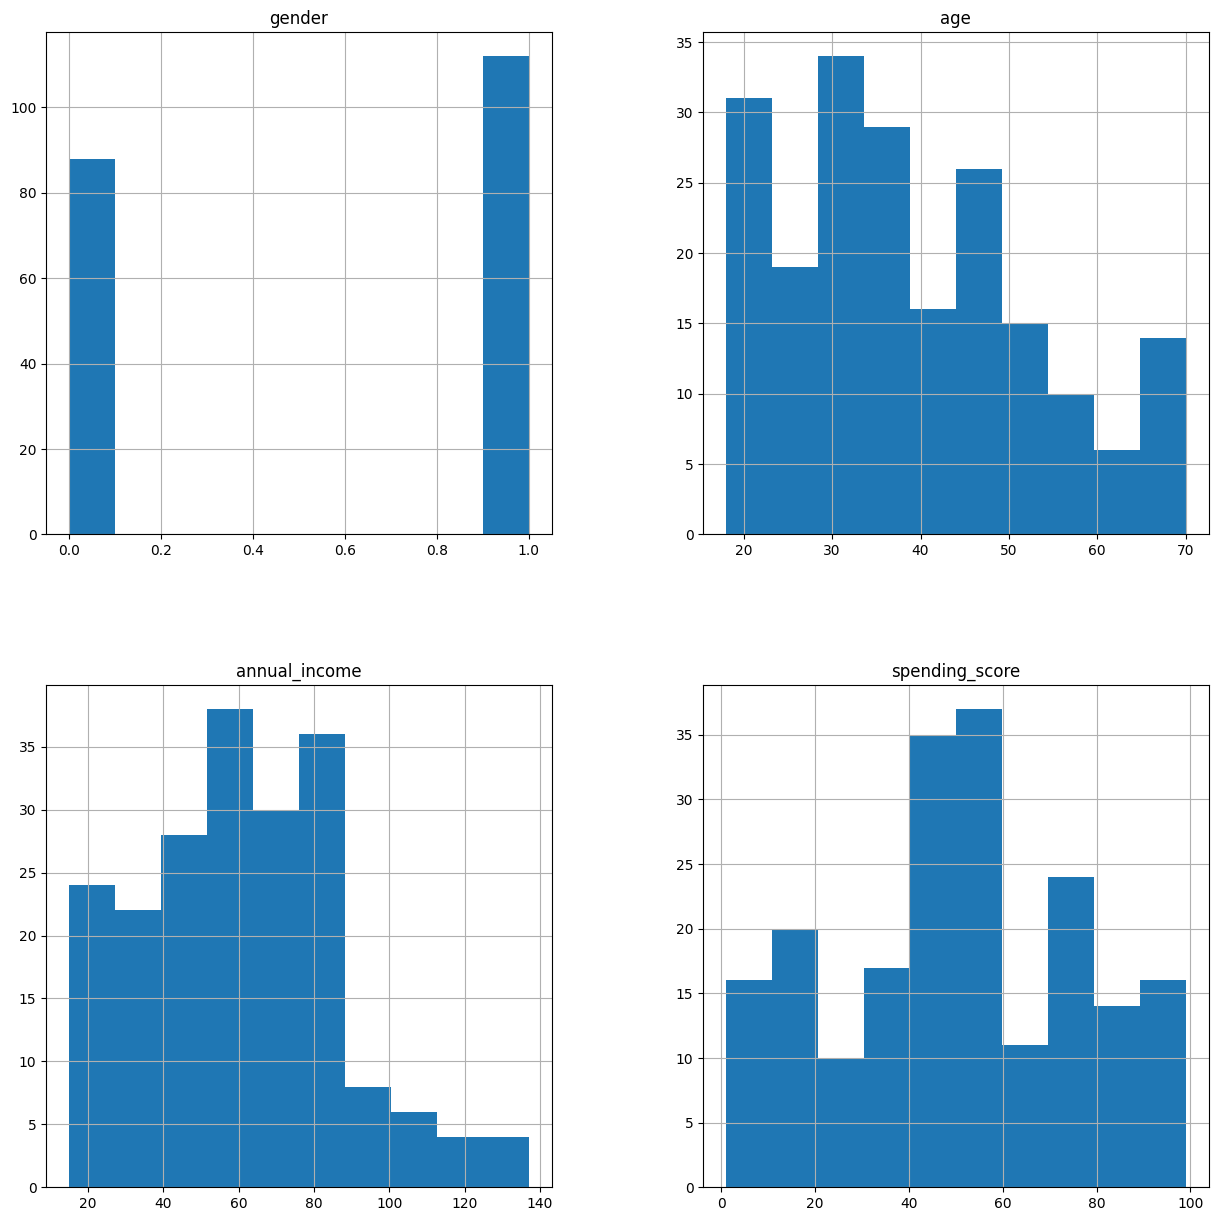

In [11]:
df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())

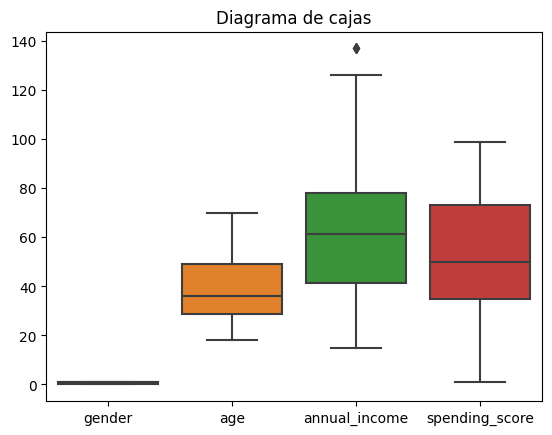

In [12]:
# Verificamos si es necesario escalar las variables
sns.boxplot(df)
plt.title('Diagrama de cajas')
plt.show()

el diagrama de cajas se utiliza para verificar si es necesario escalar las variables de los datos. Si se observan valores atípicos en el diagrama de cajas, podría ser necesario escalar las variables para reducir el efecto de estos valores extremos en el análisis posterior

In [13]:
import seaborn as sns

# mediante esta función de pueden visualizar los 'outliers'
def draw_hist_boxplot(df, feature_name):
  # se dibuja el diagrama de cajas
  sns.boxplot(x = feature_name, data = df)
  # se dibujan sobre el diagrama todos los puntos de datos que tiene la propiedad
  sns.stripplot(x = feature_name, data = df, color = "#474646")

# mediante esta función se reemplazan todos los outliers
# cualquier valor por encima o por debajo de los
# límites superior o inferior es sustituido por la mediana
def replace_outliers_with_median(df, feature_name):
  Q1 = df[feature_name].quantile(0.25)
  median = df[feature_name].quantile(0.5)
  Q3 = df[feature_name].quantile(0.75)
  IQR = Q3 - Q1
  lower_whisker = Q1 - 1.5 * IQR
  upper_whisker = Q3 + 1.5 * IQR
  df[feature_name] = np.where((df[feature_name] < lower_whisker) | 
                              (df[feature_name] > upper_whisker), 
                                median, 
                                df[feature_name])

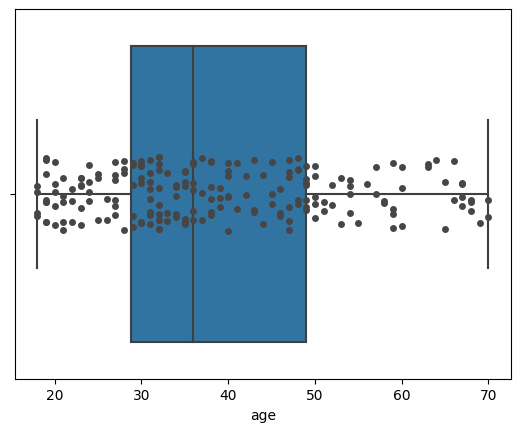

In [14]:
draw_hist_boxplot(df, 'age')

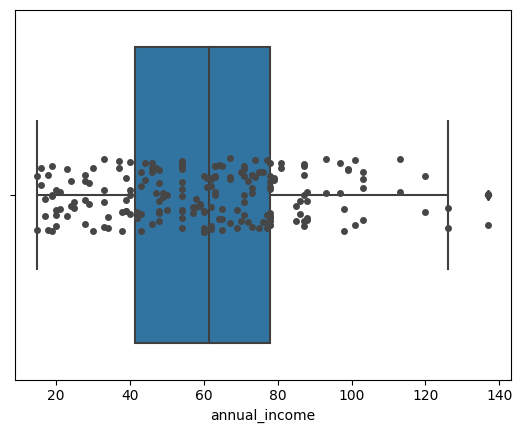

In [15]:
draw_hist_boxplot(df, 'annual_income')

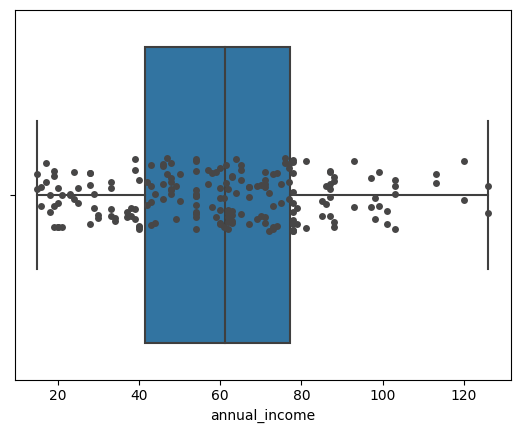

In [16]:
replace_outliers_with_median(df, 'annual_income')
draw_hist_boxplot(df, 'annual_income')

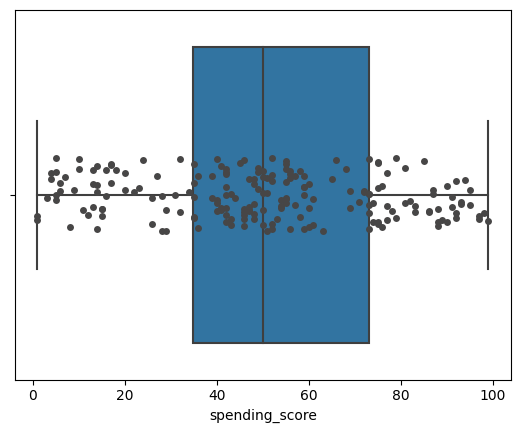

In [17]:
draw_hist_boxplot(df, 'spending_score')

In [18]:
x = df.to_numpy()
N = x.shape[0]

In [19]:
# Como se observa una diferencia de magnitud entre las variables, se procede a escalarlas
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df)

In [20]:
# Detectamos outliers y eliminamos
# Utilizamos el método de Jacknife y el algoritmo K-means
sse = []
for i in range(len(data_scaled)):
  X = np.delete(data_scaled, i, axis=0)
  kmeans = KMeans(n_clusters=4, n_init=10, random_state=100).fit(X)
  sse.append(kmeans.inertia_)

In [21]:
sigma = np.std(sse)
mu = np.mean(sse)
umbral = 2
outliers = []
for i in range(0,N):
  if np.abs(sse[i]-mu) > umbral*sigma:
    outliers.append(i)

In [22]:
outliers

[2, 134, 135, 138, 144, 162, 192, 193, 194, 195, 196, 197]

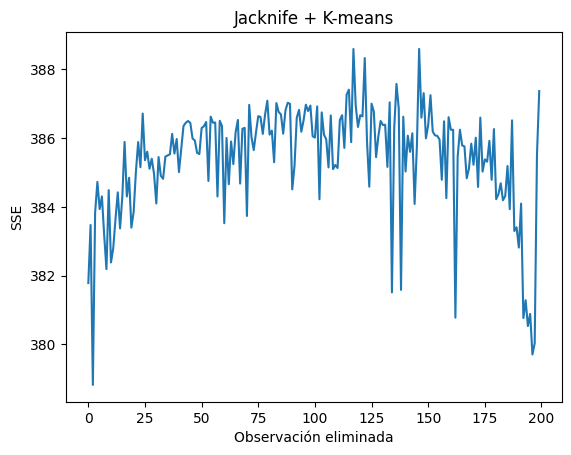

In [25]:
# Graficamos el índice SSE de cada ejecución
plt.plot(sse)
plt.title('Jacknife + K-means')
plt.xlabel('Observación eliminada')
plt.ylabel('SSE')
plt.show()

In [24]:
sse = []
for i in range(data_scaled.shape[0]):
    j_indices = [j for j in range(data_scaled.shape[0]) if j != i]
    kmeans_j = KMeans(n_clusters=4, n_init=10, random_state=0).fit(data_scaled[j_indices])
    sse.append(kmeans_j.inertia_)

<ipython-input-26-b5273d12130e>:1: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())


array([[<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'annual_income'}>,
        <Axes: title={'center': 'spending_score'}>]], dtype=object)

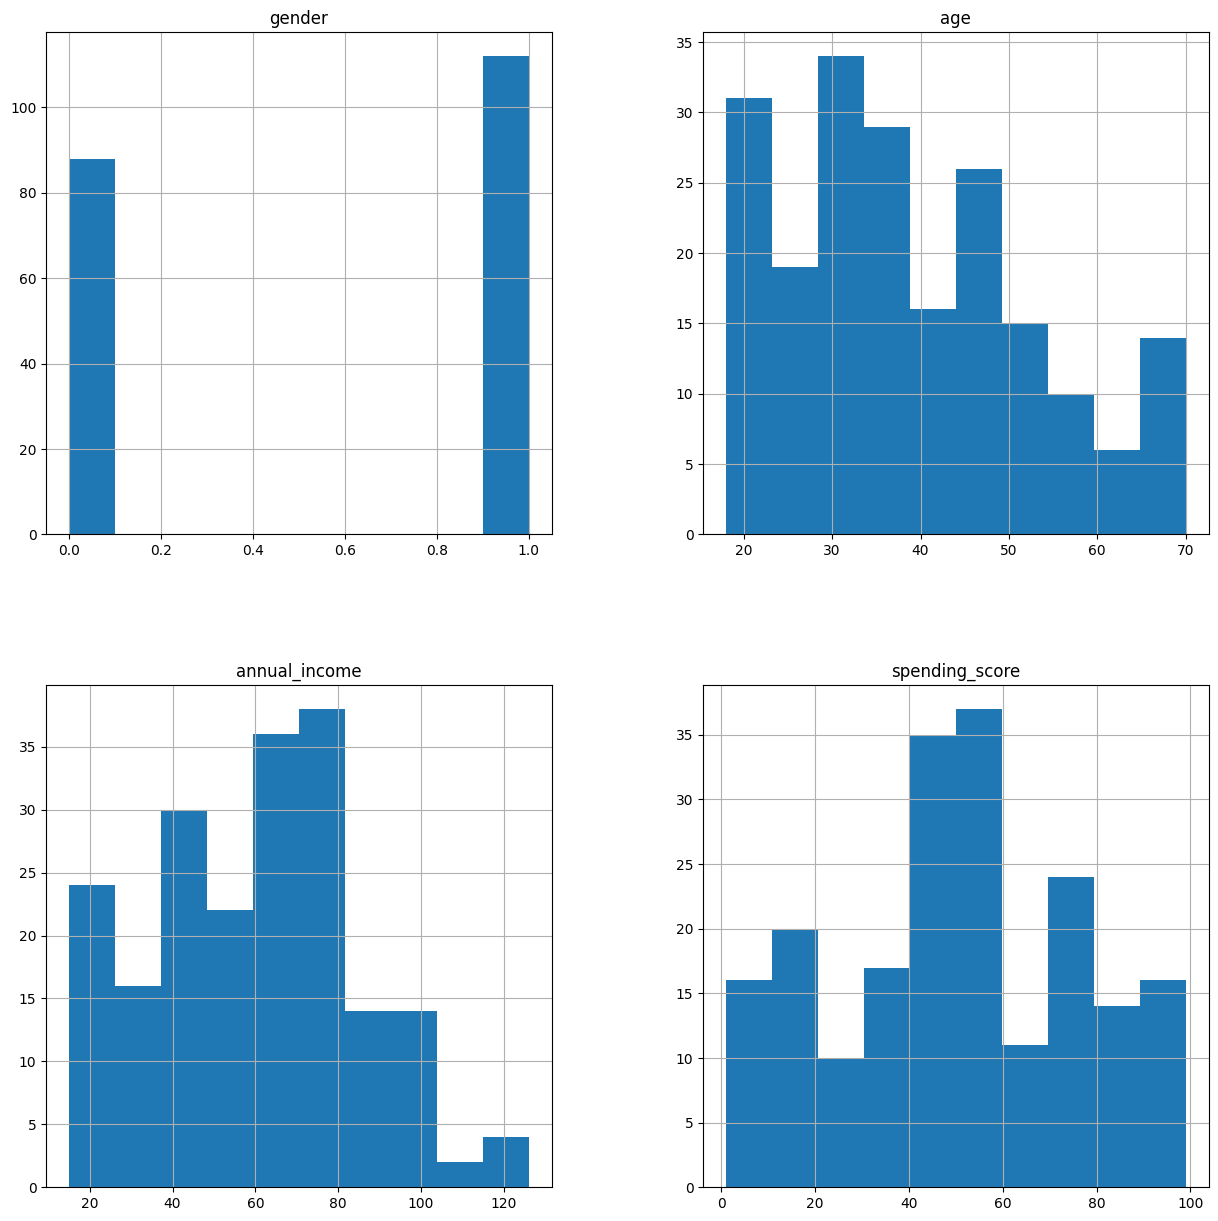

In [26]:
df[df.columns].hist(ax = plt.figure(figsize = (15, 15)).gca())

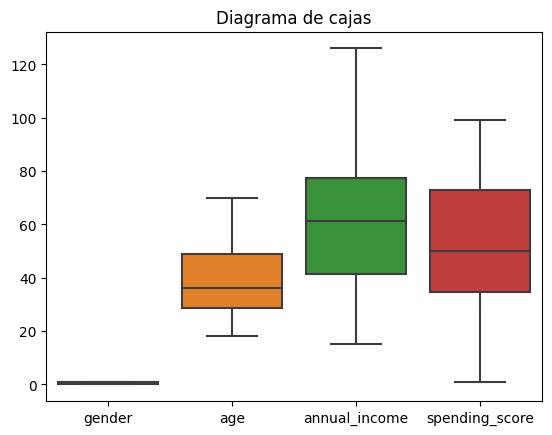

In [27]:
sns.boxplot(df)
plt.title('Diagrama de cajas')
plt.show()

## **Análisis Cluster**

In [28]:
# Ejecución de análisis cluster con un valor de k concreto y determinar el número de réplicas (n_init)
# que conduce a que la repetición de dicho algoritmo genere la misma solución
kmeans = KMeans(n_clusters=4, n_init=10, random_state=0).fit(data_scaled)
print('Silhouette score:', silhouette_score(data_scaled, kmeans.labels_))
print('Davies-Bouldin score:', davies_bouldin_score(data_scaled, kmeans.labels_))

Silhouette score: 0.29703108322312277
Davies-Bouldin score: 1.2925225505942226


In [29]:
centroids = kmeans.cluster_centers_
centroids

array([[-0.04339047, -0.44191719,  0.99000794,  1.23950275],
       [ 0.88640526,  0.60098416,  0.05252706, -0.55996755],
       [-1.12815215,  0.76431525,  0.06642288, -0.79875361],
       [ 0.0805823 , -0.98744441, -0.81536687,  0.40868516]])

## **Numero de grupos**

In [30]:
# Determinar el valor de k (número de grupos) optimizando la función BIC
bic = []
for k in range(2, 10):
    kmeans_k = KMeans(n_clusters=k, n_init=10, random_state=0).fit(data_scaled)
    bic.append(kmeans_k.score(data_scaled) + np.log(data_scaled.shape[0]) * k)

In [31]:
bic

[-578.2067215025177,
 -461.4900395234356,
 -368.40359551536136,
 -300.32536594217095,
 -244.47044634666372,
 -199.61097376754145,
 -157.98859350942175,
 -125.73691442059467]

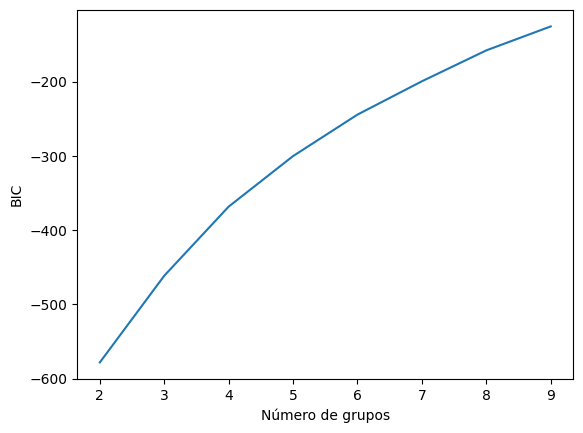

In [32]:
# Se grafica el valor BIC en función del número de grupos
plt.plot(range(2, 10), bic)
plt.xlabel('Número de grupos')
plt.ylabel('BIC')
plt.show()

In [33]:
from sklearn.mixture import GaussianMixture
def get_bic(k, X):
    gmm = GaussianMixture(n_components=k, init_params='kmeans')
    gmm.fit(X)
    return k, gmm.bic(X)

In [34]:
bic_score = pd.DataFrame([get_bic(k, X) for k in range(2, 30)], columns=['k', 'BIC'])

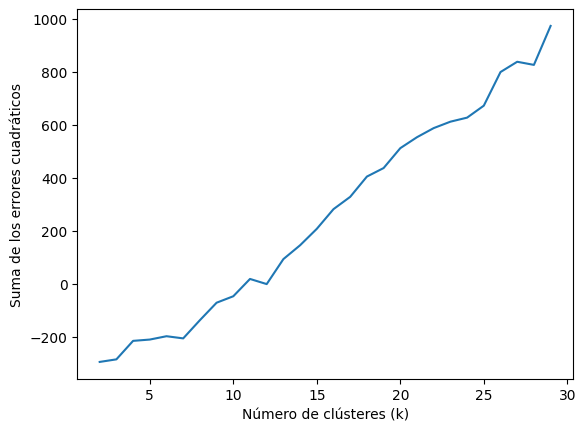

In [35]:
plt.xlabel('Número de clústeres (k)')
plt.ylabel('Suma de los errores cuadráticos')
plt.plot(bic_score['k'],bic_score['BIC'])

In [36]:
k_optimized = bic_score[bic_score.BIC == bic_score.BIC.min()]
k_optimized

,k,BIC
0,2,-296.101438


In [40]:
k = k_optimized['k'].values[0]
k

2

## **Análisis - Datos Calculados**

In [44]:
# Ejecución de análisis con los datos calculados (k y n_init)
kmeans_final = KMeans(n_clusters=k, n_init=10, random_state=0).fit(data_scaled)

In [45]:
kmeans_final.cluster_centers_

array([[-0.05241761,  0.70892251, -0.00171129, -0.69939115],
       [ 0.05565994, -0.75277339,  0.00181714,  0.74265245]])

In [46]:
np.array(kmeans_final.cluster_centers_[0][0])

array(-0.05241761)

## **Resultados**

In [47]:
# Mostrar para el análisis anterior una tabla con los siguientes datos: número de grupo, cantidad de
# observaciones de ese grupo y el centroide que representa a ese grupo (valor de cada variable)
# Esta tabla podría ser una tabla de pandas
centroids = scaler.inverse_transform(kmeans_final.cluster_centers_)

In [48]:
import plotly.express as px
labels = kmeans.labels_
df = df.copy()
df['label'] =  labels
fig = px.scatter_3d(df, x='age', y='spending_score', z='annual_income',
              color='label')
fig.show()

In [49]:
group = df.groupby(['label']).count() 
group

,gender,age,annual_income,spending_score
label,,,,
0,39,39,39,39
1,58,58,58,58
2,48,48,48,48
3,55,55,55,55


## **Observaciones Grupo 0**

In [50]:
df[df['label'] == 0].head()

,gender,age,annual_income,spending_score,label
CustomerID,,,,,
124,0,39,69.0,91,0
126,1,31,70.0,77,0
128,0,40,71.0,95,0
130,0,38,71.0,75,0
132,0,39,71.0,75,0


In [51]:
df[df['label'] == 0].describe()

,gender,age,annual_income,spending_score,label
count,39.000000,39.000000,39.000000,39.000000,39.0
mean,0.538462,32.692308,84.602564,82.128205,0.0
std,0.505035,3.728650,14.551261,9.364489,0.0
min,0.000000,27.000000,61.500000,63.000000,0.0
25%,0.000000,30.000000,74.500000,74.500000,0.0
50%,1.000000,32.000000,78.000000,83.000000,0.0
75%,1.000000,35.500000,90.500000,90.000000,0.0
max,1.000000,40.000000,126.000000,97.000000,0.0


El Grupo 0 está compuesto por 39 clientes, de los cuales el 53.8% son mujeres y el 46.2% son hombres. La edad media de este grupo es de 32.7 años, con una desviación estándar de 3.73 años. El ingreso anual promedio de este grupo es de 84.6 mil dólares, con una desviación estándar de 14.55 mil dólares. La puntuación de gasto promedio es de 82.13, con una desviación estándar de 9.36.

Si miramos con más detalle, podemos ver que el rango de edad de este grupo va desde los 27 hasta los 40 años, con un mínimo de ingresos anuales de 61.5 mil dólares y un máximo de 126 mil dólares. En cuanto a la puntuación de gasto, el rango va desde 63 hasta 97. La mayoría de los clientes de este grupo tienen ingresos anuales entre 74.5 y 90.5 mil dólares y una puntuación de gasto entre 74.5 y 90.

En resumen, podemos decir que el Grupo 0 está compuesto principalmente por clientes jóvenes (entre 27 y 40 años) con ingresos anuales relativamente altos (entre 61.5 y 126 mil dólares) y una puntuación de gasto media-alta (entre 63 y 97).

## **Observaciones Grupo 1**

In [52]:
df[df['label'] == 1].head()

,gender,age,annual_income,spending_score,label
CustomerID,,,,,
7,1,35,18.0,6,1
13,1,58,20.0,15,1
23,1,46,25.0,5,1
25,1,54,28.0,14,1
27,1,45,28.0,32,1


In [53]:
df[df['label'] == 1].describe()

,gender,age,annual_income,spending_score,label
count,58.0,58.000000,58.000000,58.000000,58.0
mean,1.0,47.224138,61.120690,35.775862,1.0
std,0.0,10.355172,24.059194,15.897747,0.0
min,1.0,23.000000,18.000000,5.000000,1.0
25%,1.0,40.250000,44.750000,23.250000,1.0
50%,1.0,47.000000,60.000000,40.000000,1.0
75%,1.0,53.500000,74.500000,48.750000,1.0
max,1.0,68.000000,126.000000,59.000000,1.0


El grupo 1 se caracteriza por tener clientes con un perfil muy diferente al grupo anterior. En este caso, se trata de personas de género femenino en su totalidad, con una edad promedio de 47 años, lo que indica que es un grupo de personas de mayor edad en comparación con el primer grupo. Además, estos clientes tienen un ingreso anual promedio de 61.12 unidades monetarias y una puntuación de gasto promedio de 35.78. Esta puntuación de gasto es significativamente menor que la del primer grupo, lo que sugiere que estos clientes gastan mucho menos en comparación con el primer grupo. Además, la desviación estándar de la puntuación de gasto es mucho menor, lo que indica que estos clientes tienen una tendencia mucho más consistente en cuanto a su nivel de gasto en el centro comercial. En general, este grupo podría describirse como clientes de mayor edad con un nivel de gasto más bajo y más consistente.